# **Influences on Medmo Booking Rates**
### Name: Zoe Birnbaum
### Link to Github Pages: https://zbirnbaum.github.io/  

A note for professor and TAs: refer to your email for a notebook containing more information about the data set.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read in data set from excel file:

In [6]:
df = pd.read_excel('ds_proj.xlsx')

## Project Goals
The goal of this project is to determine what factors influence booking rates at Medmo Inc., a healthcare in tech company. Medmo facilitates radiology appointments for their clients, both B2B and B2C. I, Zoe Birnbaum, will be analyzing their data set of all appointment requests to discover correlations between variables to identify what influences the likelihood that a requested appointment is booked.

In terms of my working timeline, I plan to touch base with this project at least 2x per week until completion. I will be working in Python notebooks on Google CoLab, as well as publishing all milestones and final works to my public repository linked above. Additionally, I plan to connect with the company biweekly with project progress and updates. I have already met with them to discuss the statistics and questions they hope to have answered by the time of project completion.

## The Data Set
This data includes all requested appointments from the company's portal from April 2018 through February 2024. Attached to each request is information regarding geographic location of the patient, type of scan/appointment, B2B vs. B2C, stage of request, date and time of request (and booking, if applicable), and more. I chose to work with this data set because of my experience working with the company and personal interest in the healthcare in tech field. The set provides a sufficient amount of data, information, and variables to allow me to follow my goal for this project.

**Research Questions**

A question I hope to answer with this data:

1. What factors are correlated with successful bookings? Including:
  
  - Geographic location of the patient
  - Time taken to book appointment after request
    - Time taken to contact patient after request
  - Type of scan
  - Number of previous cancellations (if any)
  - Channel: B2B vs B2C


**Why this data set is correct for answering the above**

The data set contains variables for all factors included in my branched-off research questions. I have over 70k scan requests to work with, which will yield valid statistics.

# Cleaning up the data

Since each observation is identified by the request ID, I'll make `TestRequestID` the index:

In [7]:
df.set_index("TestRequestID", inplace = True)

I'll drop the `Latitude` and `Longitude` columns, since the data set already includes the state and zip code, so it's redundant to have all.

In [8]:
df = df.drop(columns=['Latitude', 'Longitude'])

The column `HasReportFile` is currently represented as Boolean (1 and 0), but would be more readable with values "Yes" and "No" instead.

In [9]:
df['HasReportFile'] = df['HasReportFile'].map({
    0: "No",
    1: "Yes"
})

Since I'll be looking at the time between `DateRequested` and `DateBooked`, I'm going to create a new column in the DataFrame called `BookingTime` that represents this difference:

In [71]:
df["BookingTime"] = df["DateBooked"] - df["DateRequested"]

Data related to tasks and comments are not relevant to my research questions, so I am going to exclude that data as well:

In [12]:
df = df.drop(columns=['InternalTasks', 'ExternalTasks', 'InternalComments', 'B2BComments', 'ICComments'])

## The `State` variable:

Since I am interested in the relationship between successful bookings and geographic location, I'll start by taking a look at data related to requests by state:

In [13]:
df[["State"]].describe()

,State
count,75390
unique,49
top,NY
freq,45374


New York leads the states in the total amount of requests at 45,374, which is 59.77% of all requests:

In [14]:
percent = (df['State'].value_counts()["NY"]) / (len(df))
print(f"{percent:.2%}")

59.77%


Next, I'll generate a graph showing the percentage distribution of requests by state:

In [30]:
state_counts = df['State'].value_counts()
state_percentages = state_counts / (len(df)) * 100

<Axes: xlabel='State', ylabel='Percentage of test requests'>

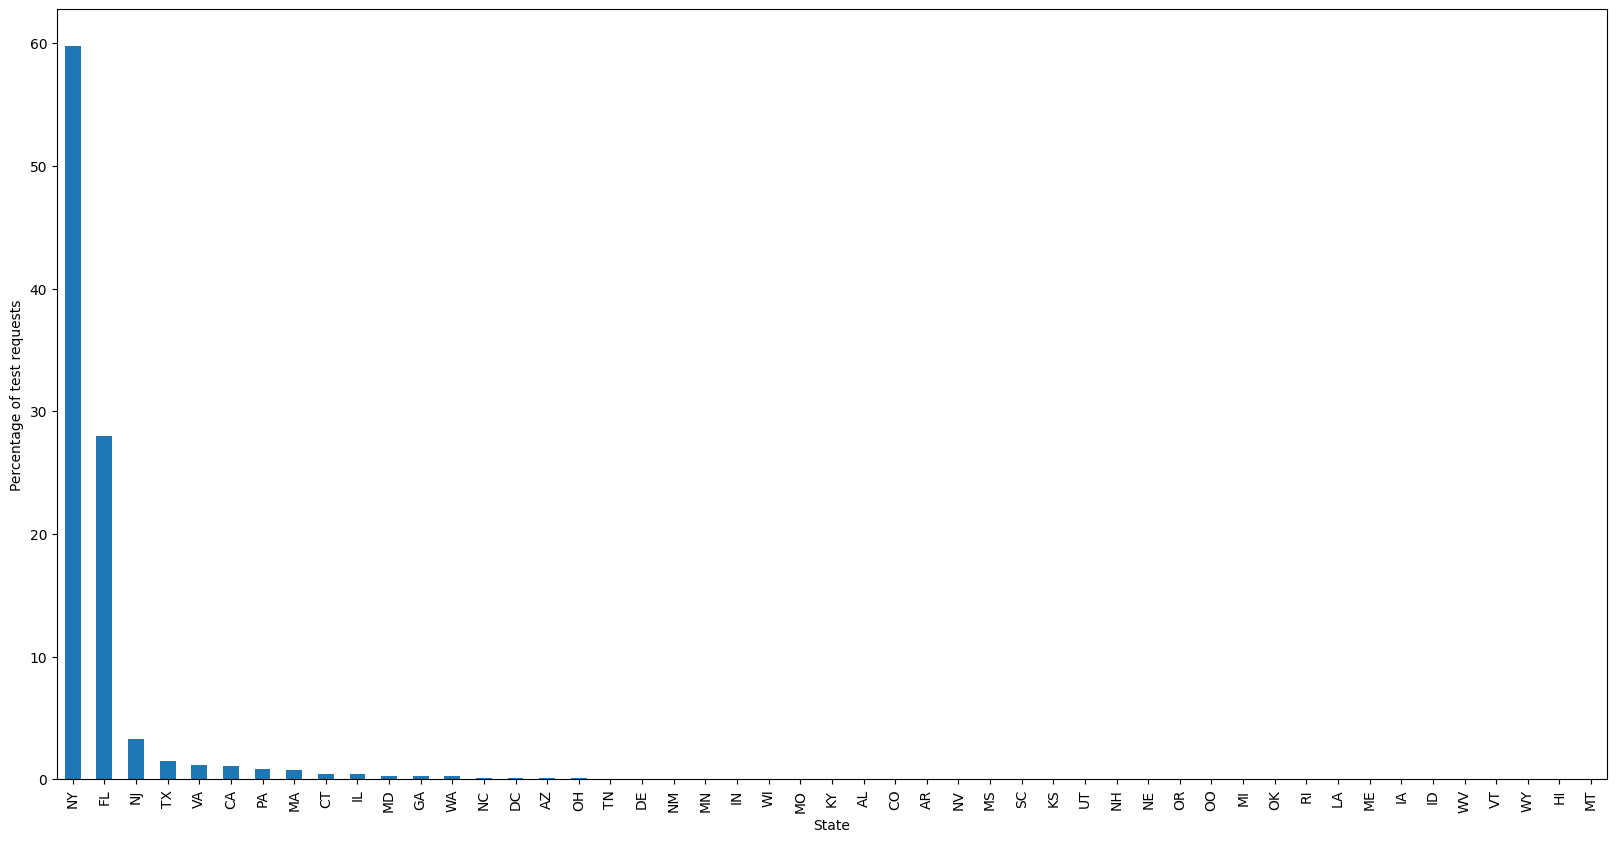

In [31]:
state_percentages.plot.bar(figsize=(20, 10), ylabel='Percentage of test requests', xlabel='State')

The leading states are: New York, Florida, and New Jersey.



A lot of the states are negligible in the context of this data set, so I'll create a new graph with the 12 states that have the most scans, so the graph is more to scale:

<Axes: xlabel='State', ylabel='Percentage of test requests'>

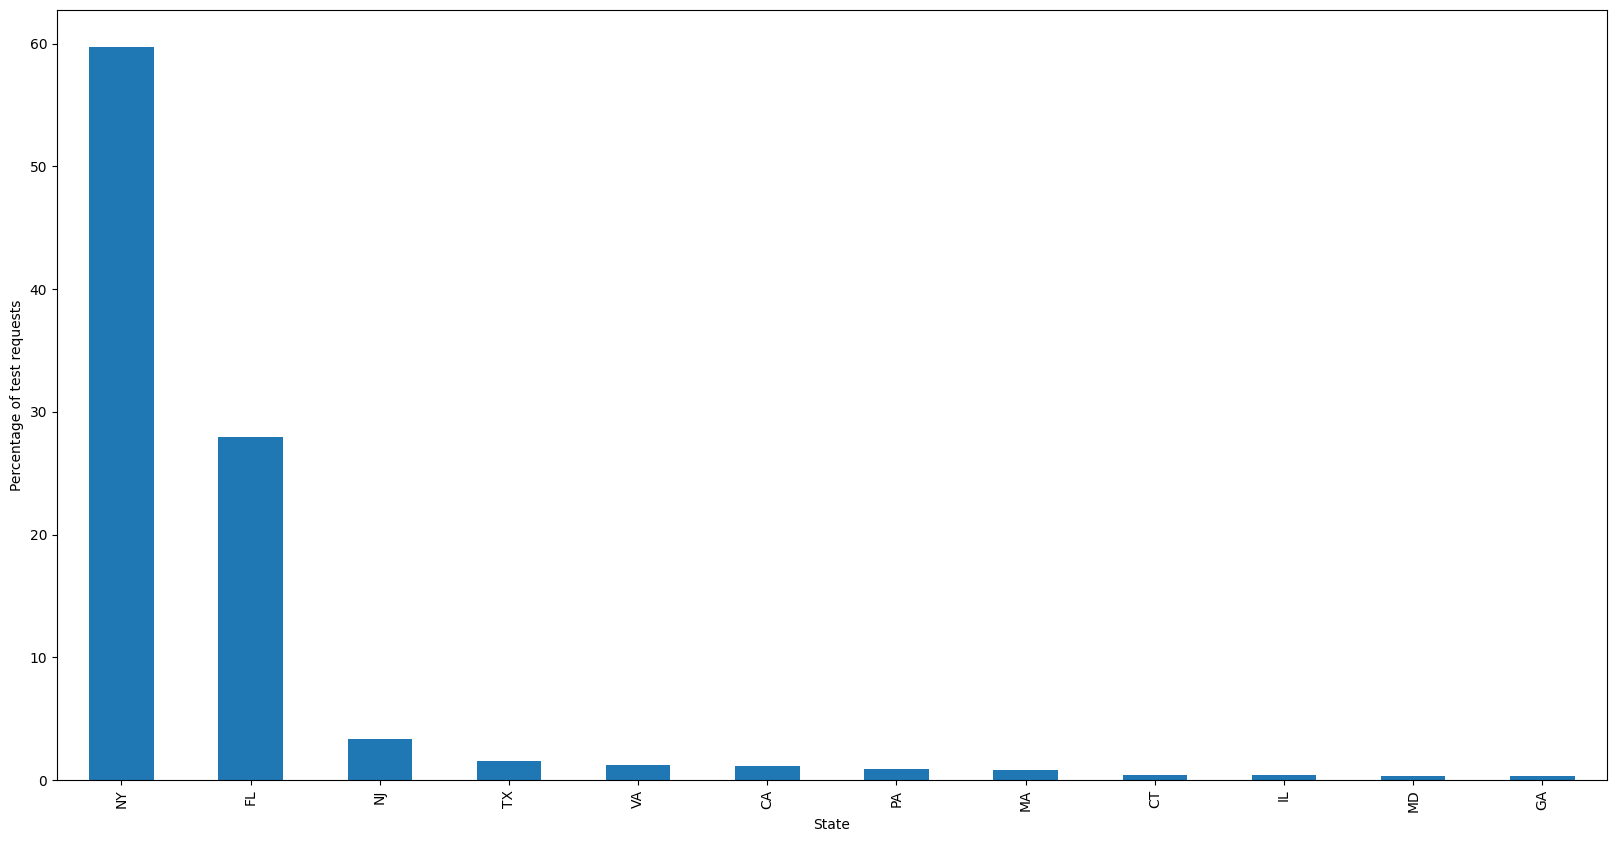

In [61]:
state_counts_2 = state_counts[["NY", "FL", "NJ", "TX", "VA", "CA", "PA", "MA", "CT", "IL", "MD",
                "GA"]]
state_percentages_2 = state_counts_2 / (len(df)) * 100
state_percentages_2.plot.bar(figsize=(20, 10), ylabel='Percentage of test requests', xlabel='State')

# "Successful" Requests

Throughout this report I will refer to requests as "successful", so let's define and find out some information about that. A successful request is a scan that is at the scheduling stage or beyond: it is scheduled or completed. What's the percentage of scan requests that fall into this category?

In [62]:
df_scheduled_completed = df[(df["StageName"] == "Scheduled") | (df["StageName"] == "Completed")]
print(f"{(len(df_scheduled_completed) / len(df)):.2%}")

57.51%


The "best-case scenario" for a scan request is one that is not only scheduled/completed, but has a report file attached. Let's see what percent of requests are at the best-case level:

In [63]:
best_case = df_scheduled_completed[df_scheduled_completed["HasReportFile"] == "Yes"]
print(f"{(len(best_case) / len(df)):.2%}")

36.42%


# The `Modality` variable:

Next, let's look at the concentrations of scan types. Amount of scheduled and completed scan requests per type of scan (`modality` variable):

<Axes: xlabel='Type of Scan (Modality)', ylabel='Number of Scan Requests'>

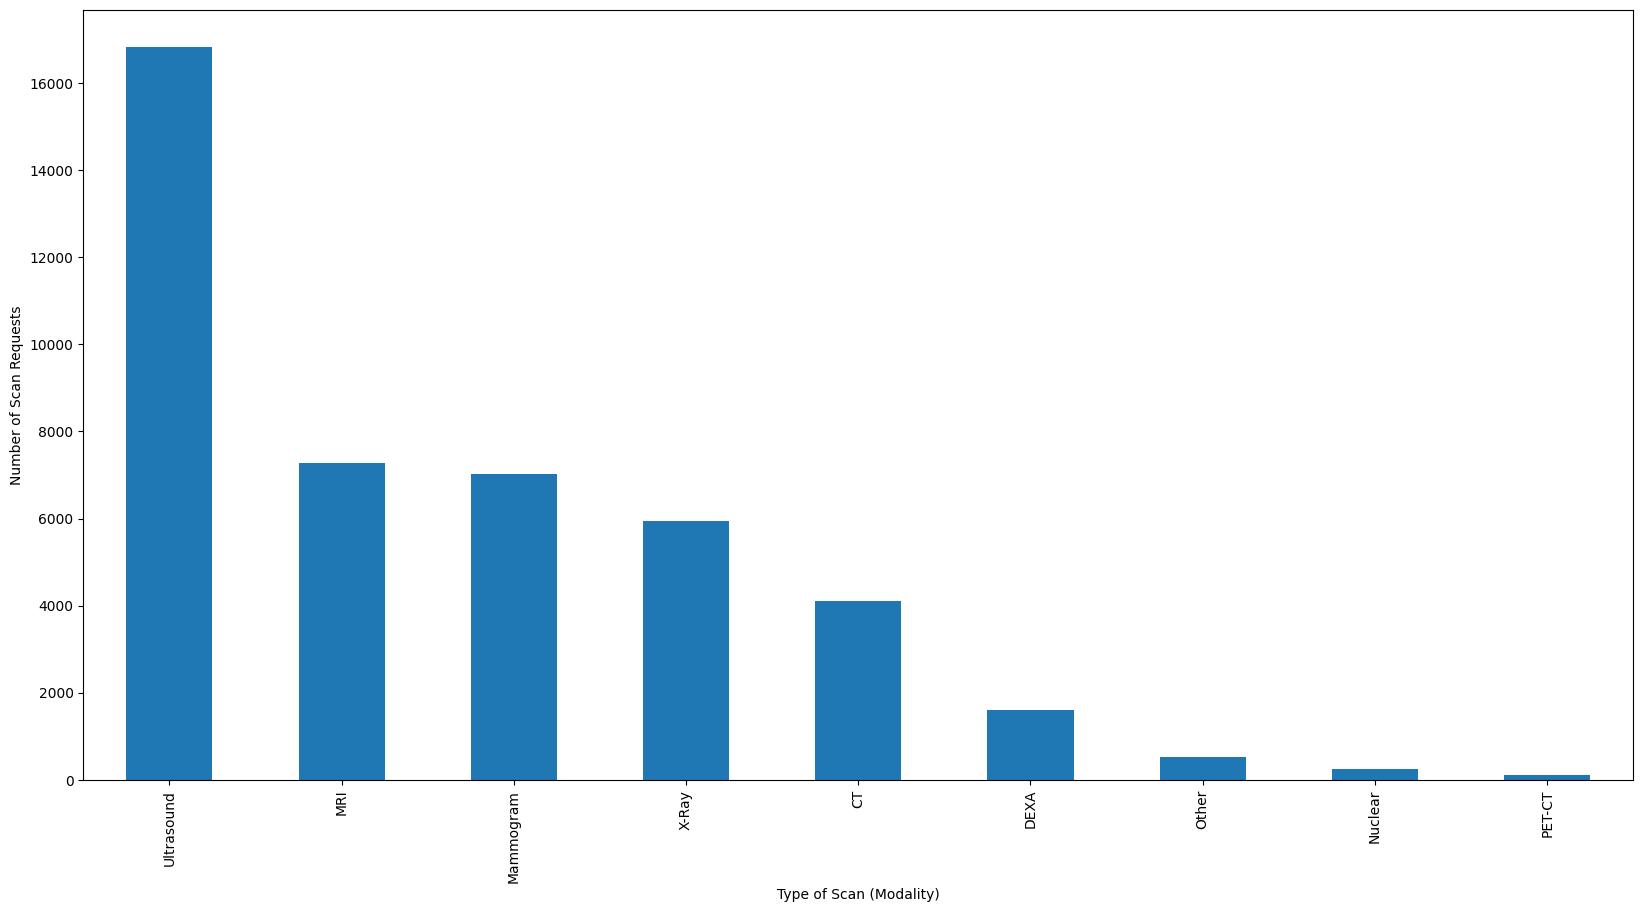

In [64]:
counts = df_scheduled_completed['Modality'].value_counts()
counts.plot.bar(figsize=(20, 10), ylabel='Number of Scan Requests', xlabel='Type of Scan (Modality)')

From this bar graph, we can see that Ultrasound is by far the most popular scan out of all those scheduled and completed, followed by MRI and Mammogram. Let's see what percentage this is vs. the percentage of Ultrasounds in all scans:

In [65]:
percent_ultrasound_success = len(df_scheduled_completed[df_scheduled_completed["Modality"] == "Ultrasound"])/len(df_scheduled_completed)
print(f"{percent_ultrasound_success:.2%}")

38.57%


In [66]:
percent_all_ultrasounds = len(df[df["Modality"] == "Ultrasound"])/len(df)
print(f"{percent_all_ultrasounds:.2%}")

34.64%


Ultrasounds make up about a third of all scan requests. There isn't much difference in the percent of Ultrasounds between the "all scans" group and the "successful" group.

# Time variables:

Next, let's look at the `TimeToA1Completion` variable, which is the time the company took to contact the patient (in minutes). A lot of these values are NaNs because that information was not always collected, so I'll create a new DataFrame without those observations for this section, and still preserve the original `df` because those observations are necessary for other computations and graphs.

In [67]:
df_timetoa1 = df.dropna(subset=["TimeToA1Completion"])

In [68]:
df_timetoa1[["TimeToA1Completion"]].describe()

,TimeToA1Completion
count,10644.000000
mean,46.669109
std,180.496039
min,0.000000
25%,0.000000
50%,14.000000
75%,46.000000
max,5884.000000


In [69]:
# How long is 5884 minutes??
5884/60/24

4.086111111111111

From this table, we can gather that most patients were contacted within 15 minutes. The average time taken to contact patient is 45 minutes, however the longest time taken to do so was 5884 minutes = ~4 days. This outlier likely drove up the mean.

Let's plot all test requests based on `TimeToA1Completion` and `BookingTime`:

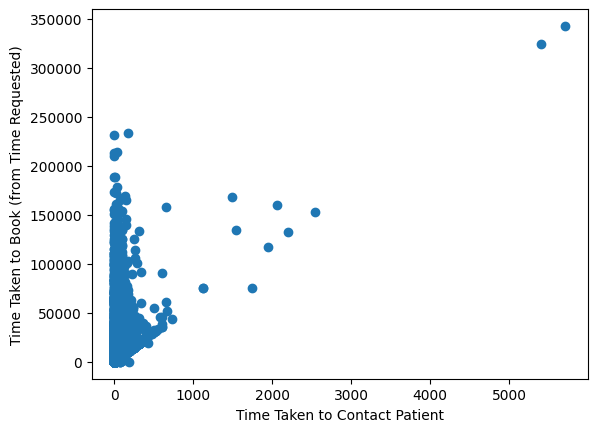

In [72]:
# This converts the time object to an integer number that represents the total amount
# of minutes, which is the same scale as TimeToA1Completion:

df["BookingTime"] = df["BookingTime"].dt.total_seconds().div(60)

plt.scatter(df["TimeToA1Completion"], df["BookingTime"])

plt.xlabel("Time Taken to Contact Patient")
plt.ylabel("Time Taken to Book (from Time Requested)")

plt.show()

With this plot we can clearly see the outliers. Let's drop them and recreate the plot to get a better view of the bulk of the points:

In [73]:
df_sub_outlier = df[(df["TimeToA1Completion"] < 1000)]

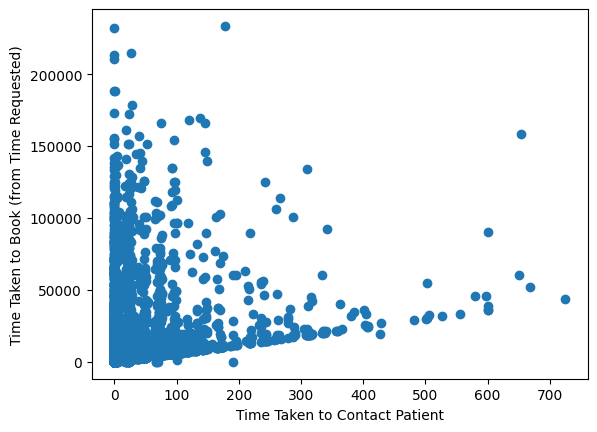

In [74]:
plt.scatter(df_sub_outlier["TimeToA1Completion"], df_sub_outlier["BookingTime"])

plt.xlabel("Time Taken to Contact Patient")
plt.ylabel("Time Taken to Book (from Time Requested)")

plt.show()

# Model ideas:

1. I plan to use the state, modality, cancellations, and channel variables (IVs) to predict whether an appointment will be booked (DV). The prediction methodology I will use is <INSERT<

2. I plan to use the following time variables to predict the likelihood of a requested appointment becoming completed (DV): time of request, time of patient contact, time of booking, time of appointment (IV). The prediction methodology I will use is <INSERT<